## Задание  
Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10  
Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf

## Загрузка и подготовка датасета CIFAR-10

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

train_x = train_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

train_y = train_y.reshape(-1).astype(np.int32)
test_y = test_y.reshape(-1).astype(np.int32)

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000,) int32
(10000,) int32


In [3]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

## Визуализация датасета CIFAR-10

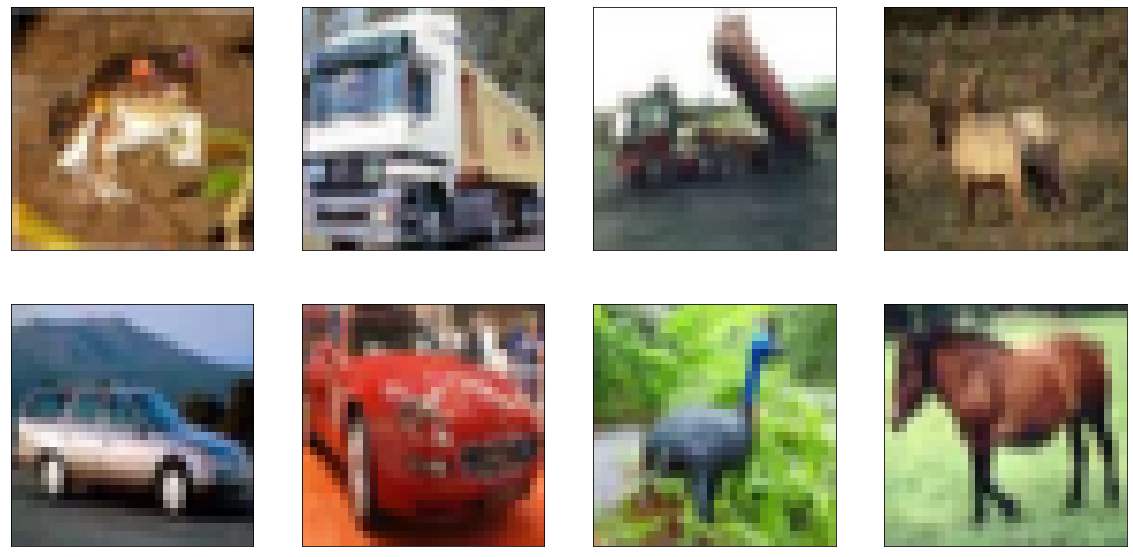

In [4]:
some_samples = train_x[:8, ...]

fig = plt.figure(figsize=(20, 10))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(2, 4, j+1)
    ax.imshow(some_samples[j,:,:,:])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание пайплайна данных

In [5]:
NUM_EPOCHS = 4
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Создание модели CNN

In [6]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
model = Model()

## Функция потерь и функция вычисления точности

In [7]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

## Подготовка к обучению

In [8]:
LEARNING_RATE = 0.001

# optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# writer = tf.summary.create_file_writer('logs/sgd')
writer = tf.summary.create_file_writer('logs/adam')

## Цикл обучения модели

In [9]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Calc and display loss/accuracy
    if iteration % 200 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])
        
        print("[%4d] Accuracy: %5.2f %%" % (
            iteration, accuracy_value.numpy()*100))
        
        with writer.as_default():
            tf.summary.scalar('accuracy', accuracy_value, iteration)
            tf.summary.scalar('loss', loss_value, iteration)

[   0] Accuracy: 13.28 %
[ 200] Accuracy: 48.05 %
[ 400] Accuracy: 56.25 %
[ 600] Accuracy: 60.94 %
[ 800] Accuracy: 60.16 %
[1000] Accuracy: 64.84 %
[1200] Accuracy: 61.72 %
[1400] Accuracy: 69.14 %
[1600] Accuracy: 67.58 %
[1800] Accuracy: 61.72 %
[2000] Accuracy: 66.80 %
[2200] Accuracy: 65.62 %
[2400] Accuracy: 65.62 %
[2600] Accuracy: 70.31 %
[2800] Accuracy: 67.19 %
[3000] Accuracy: 68.75 %
CPU times: total: 21min 21s
Wall time: 5min


## Оценка качества модели

In [10]:
%%time

test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()
print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))

Final Accuracy: 69.11 %
CPU times: total: 25 s
Wall time: 4.87 s


## Функция для инференса и отображения результата предсказания

In [11]:
def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample)
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(classes[ans]))

## Запуск предсказания для изображения случайной кртинки из CIFAR-10

In [12]:
for num, label in enumerate(classes):
    print(f'{num} - {label}')

0 - самолет
1 - автомобиль
2 - птица
3 - кот
4 - олень
5 - собака
6 - лягушка
7 - лошадь
8 - корабль
9 - грузовик


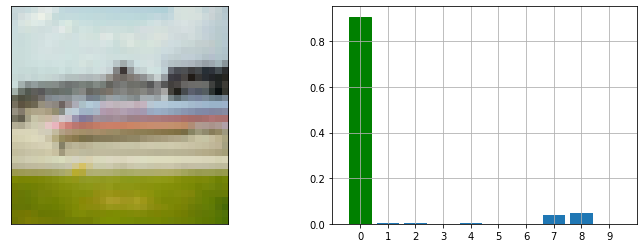

Predicted: самолет
True Answer: самолет


In [13]:
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_item(sample)

print('True Answer: {}'.format(classes[test_y[idx]]))